# Introduction
Making predictions about the future from historical data available (time series forecasting) is a very important tool with a wide variety of applications like product demand forecasting, weather, and climate forecasting, forecasting in the healthcare sector, etc. There are two main approaches to time series forecasting – statistical approaches and neural network models. The most popular statistical method for time series forecasting is the ARIMA (Autoregressive Integrated Moving Average) family with AR, MA, ARMA, ARIMA, ARIMAX, and SARIMAX methods. In this article, however, we are going to discuss a neural network approach to time series forecasting using extreme learning machines.

Extreme learning machines are single hidden layer feedforward neural networks proposed by Huang et. al. in 2004. They have extremely fast learning speed, good generalization performance, and universal approximation capabilities. The weights and the biases of the hidden layer nodes are set randomly, thus saving time required in hyper tuning by backpropagation. The weights of the output layer can be determined analytically by a Moore Penrose inverse operation.

In [1]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.7530, 0.6084, 0.2486],
        [0.1130, 0.8165, 0.4345],
        [0.2344, 0.3485, 0.2291],
        [0.9468, 0.9210, 0.4220],
        [0.8013, 0.7119, 0.2162]])


# How do ELMs work?
The ELM algorithm can be described as follows :

1. The weights and the biases of the hidden layer are randomly assigned.
2. The hidden layer output matrix (H) is calculated by multiplying the inputs with the randomly assigned weights,  adding biases, and finally applying an activation function on the output.
3. The output weight matrix is calculated by multiplying the Moore Penrose inverse of H (hidden layer output matrix) with the training data matrix (T).
4. The output weight matrix is finally used to make predictions on new data.

A pictorial depiction of an extreme learning machine is given below :

![title](ELM.png)

# Why use ELMs?
The main advantage of extreme learning machines is that they take much less training time compared to traditional back-propagated neural networks. In traditional feedforward neural network models, the weights and the biases of the hidden layers are tuned iteratively with slow gradient-based learning algorithms like backpropagation. Since the hidden layer weights and the biases are randomly assigned in ELMs, they are computationally much faster than traditional deep neural network models. In addition to their computational efficiency, ELMs have been shown to be more advantageous in terms of efficiency and generalization performance over traditional FNN algorithms on a wide range of benchmark problems from different fields

# Time series forecasting – ELMs vs traditional methods 
In the context of time series forecasting, ELMs can be a really powerful tool. Statistical approaches to times series modeling like ARIMA models can only be applied to stationary time series (whose properties do not depend on the time at which the series is observed), they fail to capture seasonality. Neural network models can overcome this difficulty as they help in capturing the non-linearity in data due to external factors. Traditional backpropagated NNs however suffer from certain drawbacks like overfitting, slow learning speed, etc. ELMs are better than backpropagated NNs as they have extremely fast learning speed, good generalization performance, and least human intervention.

# Overcoming the disadvantages
The main disadvantage of ELMs is that the stochasticity involved in the algorithm might sometimes lead to sub-optimal performance in terms of accuracy. To overcome this, one must properly tune the hyperparameters involved like the number of hidden nodes, the type of activation function, etc. This tuning is sometimes done using metaheuristic optimization algorithms like Bayesian Optimisation, Genetic Algorithms, Teaching-Learning Based Optimisation algorithm, etc. A number of variants of ELM have also come out which overcome these drawbacks like the optimally pruned ELM, online sequential ELM, etc. but their discussion is outside the purview of this blog.

Since their inception, ELMs have been used in a wide variety of fields like object recognition, feature learning, clustering, classification, regression, and time-series modeling with promising results. Now that we know what ELMs are and how they work, let us dive right into trying to perform time series forecasting with them.

# Loading the Time Series Dataset 
We are going to be using a product demand dataset from a gaming console store. The dataset has daily sales data of a product from January 2013 to December 2017. Data from January 2013 to September 2017 is used for training and October 2017 to December 2017 data is used for testing.

In [38]:
import pandas as pd
from datetime import datetime
def parser(x):
    return datetime.strptime(x,"%Y-%m-%d")
data = pd.read_csv('Sales_Data.txt', header = 0, parse_dates=[0],index_col=0,squeeze=True, date_parser=parser)
data

/var/folders/_8/n21p2rcd5sd4yqhw8z4mbdr40000gn/T/ipykernel_50425/2439318576.py:5: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  data = pd.read_csv('Sales_Data.txt', header = 0, parse_dates=[0],index_col=0,squeeze=True, date_parser=parser)


date
2013-01-01    1742
2013-01-02    1808
2013-01-03    1887
2013-01-04    1983
2013-01-05    2087
              ... 
2017-12-27    2624
2017-12-28    2839
2017-12-29    3025
2017-12-03    3151
2017-12-31    3370
Name: sales, Length: 1826, dtype: int64

We can visualize the time series data using matplotlib :

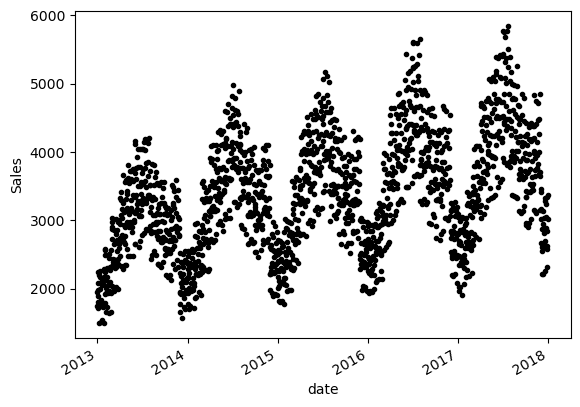

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
data = data.astype(float)
data
data.plot(style='k.',ylabel='Sales')
plt.show()

In [10]:
import scipy
print(scipy.__version__)


1.9.1


We can see that the dataset shows certain clear trends, which makes forecasting easier.

Next, we import certain necessary packages and convert the data to a NumPy array to make operations easier :

In [40]:
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from scipy.linalg import pinv
data = np.array(data)
data = np.reshape(data, (-1, 1))
data

array([[1742.],
       [1808.],
       [1887.],
       ...,
       [3025.],
       [3151.],
       [3370.]])

# Making Train-Test Splits and Data Normalisation  
We need to split the data into training and testing parts and perform data normalization.

In [41]:
m = 14
per = (1736 - m)/1826
size = int(len(data) * per)
d_train, d_test = data[0:size], data[size:len(data)]
mean_train = np.mean(d_train)
sd_train = np.std(d_train)
d_train = (d_train-mean_train)/sd_train
d_test = (d_test-mean_train)/sd_train

There are a number of things to note in the above code snippet. We first split the data into training and testing parts. We will try to forecast the last 3 months of daily sales and use the rest of the data for training. For predicting the daily sales data at any time step, we need to provide values of previous time steps data as input (which is known as the lag). Here, we have chosen the lag size as 14, i.e. sales data of the previous 14 days is used to predict the next day’s sales data. m here represents the lag size. We have accordingly performed the train-test split.

Data normalization is an essential preprocessing task to be performed in any forecasting job. In this code, the time series data has been normalized by subtracting the mean and then dividing by the standard deviation of data. The predictions will need to be transformed back to the original scale using the corresponding denormalization equation.

Next, we need to reshape the train and test data into the form that needs to be fed into the ELM.

In [42]:
X_train = np.array([d_train[i][0] for i in range(m)])
y_train = np.array(d_train[m][0])
for i in range(1,(d_train.shape[0]-m)):
    l = np.array([d_train[j][0] for j in range(i,i+m)])
    X_train = np.vstack([X_train,l])
    y_train = np.vstack([y_train,d_train[i+m]])
X_test = np.array([d_test[i][0] for i in range(m)])
y_test = np.array(d_test[m][0])
for i in range(1,(d_test.shape[0]-m)):
    l = np.array([d_test[j][0] for j in range(i,i+m)])
    X_test = np.vstack([X_test,l])
    y_test = np.vstack([y_test,d_test[i+m]])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
#> (1708, 14)
#> (1708, 1)
#> (90, 14)
#> (90, 1)

len(X_train[0])

(1708, 14)
(1708, 1)
(90, 14)
(90, 1)


14

As mentioned earlier, we are feeding 14 previous time steps data as input to predict the data at the next step. We use simple NumPy operations to reshape our data so that our final train input data is a 1708 X 14 matrix and the final train output data is a 1708 X 1 matrix. Similar operations are performed for the test data.

# Building the ELM model
We have already discussed the ELM algorithm earlier. The ELM model has a number of hyperparameters that need to be optimized for optimal performance – lag size, number of hidden nodes, input weights and biases, and the type of activation function.



In [43]:
import scipy.stats as stats
input_size = X_train.shape[1]
hidden_size = 100   #no. of hidden neurons
mu, sigma = 0, 1
w_lo = -1 
w_hi = 1
b_lo = -1 
b_hi = 1
#initialising input weights and biases randomly drawn from a truncated normal distribution
input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
def relu(x):      #hidden layer activation function
    return np.maximum(x, 0, x)

We are choosing the number of neurons in the hidden layer (hidden_size) as 100. The weights and the biases of the hidden layer are randomly drawn from a truncated normal distribution from (-1,1). The relu activation function is used. We have written our own function ‘relu’ for performing relu activation. You can explore using other activation functions and changing the number of hidden nodes to improve accuracy further.

In [44]:
#Produit scalaire, ou en anglais dot scalar,

#On doit calculer le billet pour etre objectif , cest le parametre une observation pour faire la comparasion et equilibrer mon modèle



def hidden_nodes(X):
    G = np.dot(X, input_weights) #Produit scalaire de x par le poids
    G = G + biases # On ajoute le billet
    H = relu(G) # On fait la fonction d'activation 
    return H
output_weights = np.dot(pinv(hidden_nodes(X_train)), y_train)
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out
prediction = predict(X_test)

The function ‘hidden_nodes’ calculates the hidden layer output matrix by multiplying the weights with input vectors and adding the biases. Relu activation is also applied to the output. The Moore Penrose inverse of the hidden layer output matrix is calculated using the pinv2 function from scipy.linalg library. The output weights matrix is stored in output_weights. The function ‘predict’ is used to perform predictions on the test data X_test.

# Evaluating Time Series Forecasting
It is important to evaluate the quality of forecasts using some sort of performance metric.

In [45]:
#Pour faire la stabilite de l'algorithme alors on doit garder les valeurs positive et si la valeur est negative alors on met 0
#Si la fonction Sigmoide est proche de 1 alors il va continer sinon si elle est proche de 0 alors son avis de compte pas trop  
#La derivé utiliser pour trouver la valeur des points optimal 
# Le gradient decendant permet de minimiser les erreur afin de maximiser sur la precision , et la derivee en trouvons les derives(fourmi aveugle sur une montagne)

correct = 0
total = X_test.shape[0]
y_test = (y_test*sd_train) + mean_train
prediction = (prediction*sd_train) + mean_train
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, prediction))
print('Test RMSE: %.3f' % rmse)
mape_sum = 0
for i,j in zip(y_test,prediction):
    mape_sum = mape_sum + (abs((i-j)/i))
mape = (mape_sum/total)*100
mpe_sum = 0
for i,j in zip(y_test,prediction):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/total)*100
print('Test MAPE: %.3f' % mape)
print('Test MPE: %.3f' % mpe)


Test RMSE: 166.320
Test MAPE: 2.800
Test MPE: -0.836


Three performance metrics are used to evaluate the quality of forecasts – root mean squared error (RMSE), mean percentage error (MPE) and mean absolute percentage error (MAPE). Keep in mind that we need to denormalize the data by multiplying with standard deviation and adding the mean before calculating RMSE, MPE, MAPE, etc. The mean_squared_error function from sklearn.metrics library is used to calculate RMSE while MPE and MAPE are directly calculated using their respective formulae. I obtained the test MAPE as 2.767% but your result might vary due to the stochasticity involved in the algorithm.



# How does Time Series Forecasting look?  
We have reached the end of the forecasting task and need to see how our predicted forecasts look. We plot the results using matplotlib again.### 

(array([2000., 2500., 3000., 3500., 4000., 4500., 5000., 5500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

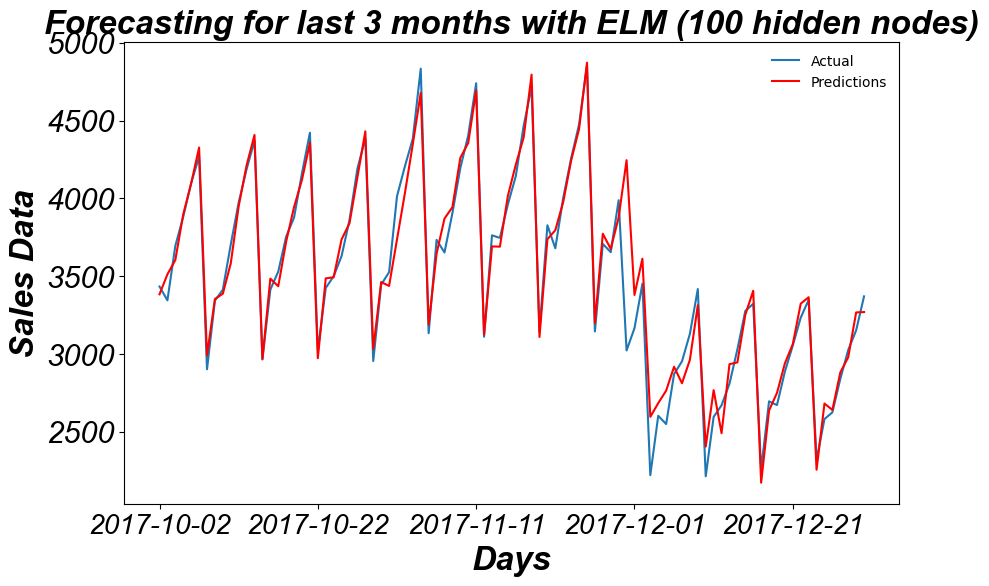

In [18]:
# plot forecasts against actual outcomes
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(y_test,label = 'Actual')
ax.plot(prediction, color='red',label = 'Predictions')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Days',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.ylabel('Sales Data',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title('Forecasting for last 3 months with ELM (100 hidden nodes)',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.xticks([0,20,40,60,80],['2017-10-02','2017-10-22','2017-11-11','2017-12-01','2017-12-21'],fontname="Arial", fontsize = 20, style='italic')
plt.yticks(fontname="Arial", fontsize = 22, style='italic')

# EXERCICE POUR PREDIRE LE NOMBRE DE COMPTAMINISATION DU COVID 19 DANS NOTRE PAYS 

In [47]:
import pandas as pd
from datetime import datetime
def parser(x):
    return datetime.strptime(x,"%Y-%m-%d")
data = pd.read_csv('COVID-19.csv', header = 0)
data

,Date,Country_Region,Province_State,Difference,Prep_Flow_Runtime,Latest_Date,Case_Type,Cases,Lat,Long
0,3/9/2020,India,NaN,0,3/24/2020 9:39:03 AM,3/23/2020,Deaths,0,21.000000,78.000000
1,3/8/2020,India,NaN,0,3/24/2020 9:39:03 AM,3/23/2020,Deaths,0,21.000000,78.000000
2,3/7/2020,India,NaN,0,3/24/2020 9:39:03 AM,3/23/2020,Deaths,0,21.000000,78.000000
3,3/6/2020,India,NaN,0,3/24/2020 9:39:03 AM,3/23/2020,Deaths,0,21.000000,78.000000
4,3/5/2020,India,NaN,0,3/24/2020 9:39:03 AM,3/23/2020,Deaths,0,21.000000,78.000000
...,...,...,...,...,...,...,...,...,...,...
35497,1/27/2020,Syria,NaN,0,3/24/2020 9:39:03 AM,3/23/2020,Confirmed,0,34.802075,38.996815
35498,1/26/2020,Syria,NaN,0,3/24/2020 9:39:03 AM,3/23/2020,Confirmed,0,34.802075,38.996815
35499,1/25/2020,Syria,NaN,0,3/24/2020 9:39:03 AM,3/23/2020,Confirmed,0,34.802075,38.996815
35500,1/24/2020,Syria,NaN,0,3/24/2020 9:39:03 AM,3/23/2020,Confirmed,0,34.802075,38.996815


In [50]:
# Filtrer les lignes avec Case_Type égal à "Confirmed" et Cases égal à 1
df_filtered = data[(data['Case_Type'] == 'Confirmed') & (data['Cases'] == 1)]

# Regrouper les données par date et compter le nombre de lignes par groupe
df_grouped = df_filtered.groupby('Date').count()


In [52]:
data = df_grouped.loc[:, ['Cases']]
data

,Cases
Date,
1/23/2020,7
1/24/2020,4
1/25/2020,4
1/26/2020,7
1/27/2020,9
...,...
3/5/2020,29
3/6/2020,34
3/7/2020,36


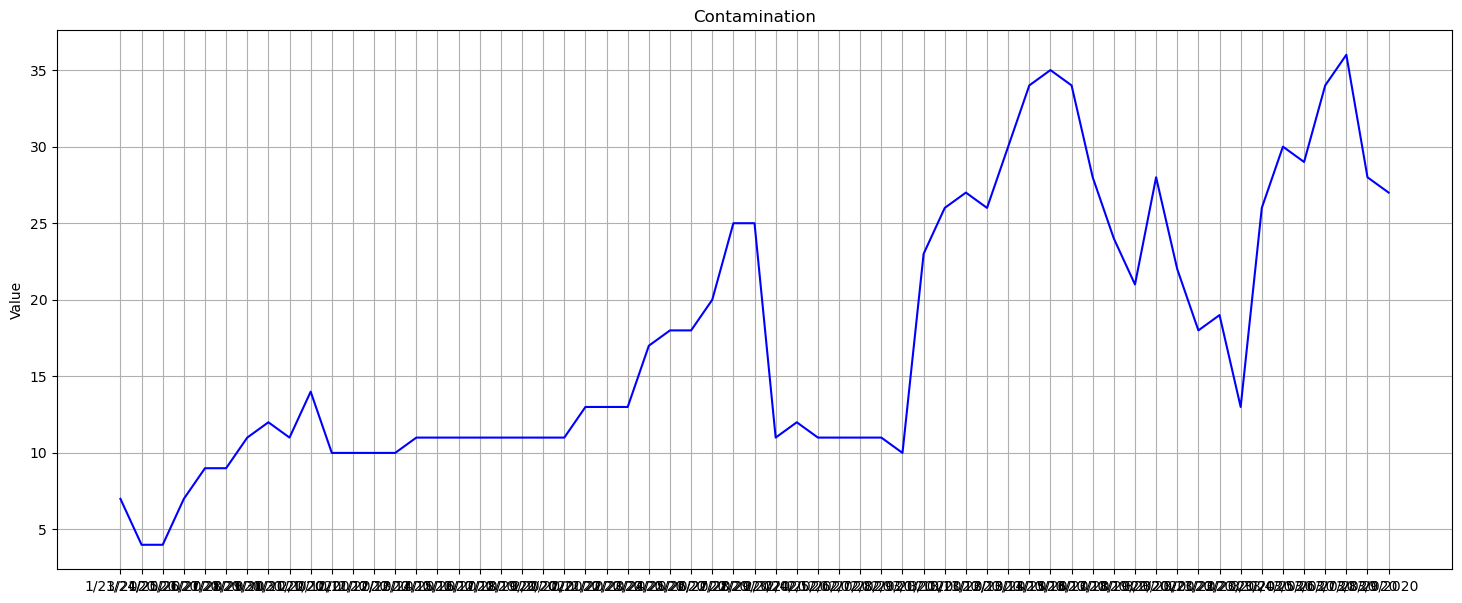

In [55]:
# plot time plot 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
ax.set_title("Contamination")
ax.grid(True)
#ax.set_xlabel("Index")
ax.set_ylabel("Value")
ax.plot(
    data['Cases'],
    color='blue', label='Data');

In [56]:
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from scipy.linalg import pinv
data = data.loc[:,'Cases']
data = np.array(data)
data = np.reshape(data, (-1, 1))
data

array([[ 7],
       [ 4],
       [ 4],
       [ 7],
       [ 9],
       [ 9],
       [11],
       [12],
       [11],
       [14],
       [10],
       [10],
       [10],
       [10],
       [11],
       [11],
       [11],
       [11],
       [11],
       [11],
       [11],
       [11],
       [13],
       [13],
       [13],
       [17],
       [18],
       [18],
       [20],
       [25],
       [25],
       [11],
       [12],
       [11],
       [11],
       [11],
       [11],
       [10],
       [23],
       [26],
       [27],
       [26],
       [30],
       [34],
       [35],
       [34],
       [28],
       [24],
       [21],
       [28],
       [22],
       [18],
       [19],
       [13],
       [26],
       [30],
       [29],
       [34],
       [36],
       [28],
       [27]])

In [61]:
m = 2
per = (1736 - m)/1826
size = int(len(data) * per)
d_train, d_test = data[0:size], data[size:len(data)]
mean_train = np.mean(d_train)
sd_train = np.std(d_train)
d_train = (d_train-mean_train)/sd_train
d_test = (d_test-mean_train)/sd_train

In [62]:
X_train = np.array([d_train[i][0] for i in range(m)])
y_train = np.array(d_train[m][0])
for i in range(1,(d_train.shape[0]-m)):
    l = np.array([d_train[j][0] for j in range(i,i+m)])
    X_train = np.vstack([X_train,l])
    y_train = np.vstack([y_train,d_train[i+m]])
X_test = np.array([d_test[i][0] for i in range(m)])
y_test = np.array(d_test[m][0])
for i in range(1,(d_test.shape[0]-m)):
    l = np.array([d_test[j][0] for j in range(i,i+m)])
    X_test = np.vstack([X_test,l])
    y_test = np.vstack([y_test,d_test[i+m]])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
#> (1708, 14)
#> (1708, 1)
#> (90, 14)
#> (90, 1)

len(X_train[0])

(55, 2)
(55, 1)
(2, 2)
(2, 1)


2

In [63]:
import scipy.stats as stats
input_size = X_train.shape[1]
hidden_size = 100   #no. of hidden neurons
mu, sigma = 0, 1
w_lo = -1 
w_hi = 1
b_lo = -1 
b_hi = 1
#initialising input weights and biases randomly drawn from a truncated normal distribution
input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
def relu(x):      #hidden layer activation function
    return np.maximum(x, 0, x)

In [64]:
#Produit scalaire, ou en anglais dot scalar,

#On doit calculer le billet pour etre objectif , cest le parametre une observation pour faire la comparasion et equilibrer mon modèle



def hidden_nodes(X):
    G = np.dot(X, input_weights) #Produit scalaire de x par le poids
    G = G + biases # On ajoute le billet
    H = relu(G) # On fait la fonction d'activation 
    return H
output_weights = np.dot(pinv(hidden_nodes(X_train)), y_train)
def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out
prediction = predict(X_test)

In [65]:
#Pour faire la stabilite de l'algorithme alors on doit garder les valeurs positive et si la valeur est negative alors on met 0
#Si la fonction Sigmoide est proche de 1 alors il va continer sinon si elle est proche de 0 alors son avis de compte pas trop  
#La derivé utiliser pour trouver la valeur des points optimal 
# Le gradient decendant permet de minimiser les erreur afin de maximiser sur la precision , et la derivee en trouvons les derives(fourmi aveugle sur une montagne)

correct = 0
total = X_test.shape[0]
y_test = (y_test*sd_train) + mean_train
prediction = (prediction*sd_train) + mean_train
# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, prediction))
print('Test RMSE: %.3f' % rmse)
mape_sum = 0
for i,j in zip(y_test,prediction):
    mape_sum = mape_sum + (abs((i-j)/i))
mape = (mape_sum/total)*100
mpe_sum = 0
for i,j in zip(y_test,prediction):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/total)*100
print('Test MAPE: %.3f' % mape)
print('Test MPE: %.3f' % mpe)


Test RMSE: 34.924
Test MAPE: 101.900
Test MPE: 79.555


In [66]:
y_test

array([[28.],
       [27.]])

(array([-30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

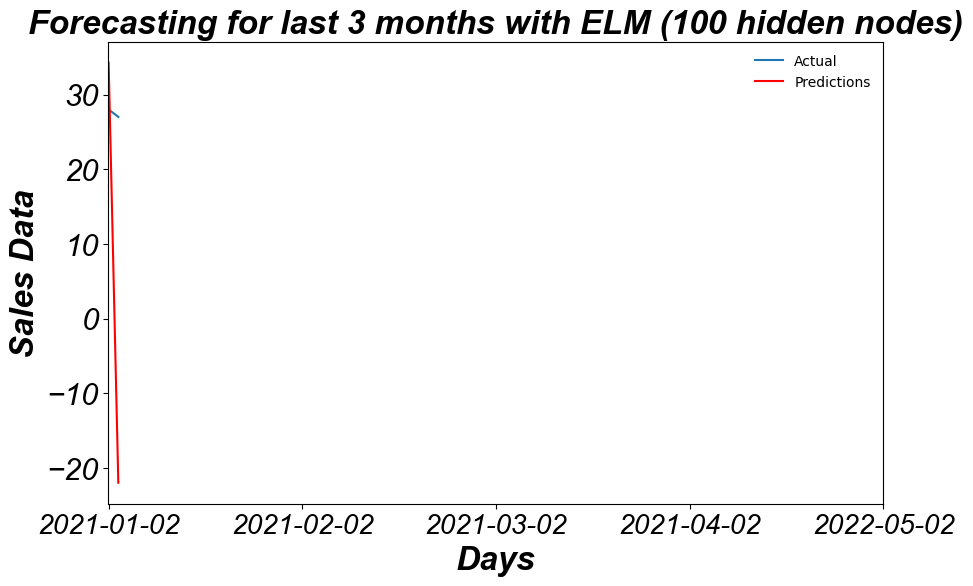

In [69]:
# plot forecasts against actual outcomes
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(y_test,label = 'Actual')
ax.plot(prediction, color='red',label = 'Predictions')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Days',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.ylabel('Sales Data',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.title('Forecasting for last 3 months with ELM (100 hidden nodes)',fontname="Arial", fontsize=24, style='italic', fontweight='bold')
plt.xticks([0,20,40,60,80],['2021-01-02','2021-02-02','2021-03-02','2021-04-02','2022-05-02'],fontname="Arial", fontsize = 20, style='italic')
plt.yticks(fontname="Arial", fontsize = 22, style='italic')